Mean MSE: Leave one out 2.5959, 10 folds 2.7761, 5 folds 2.7961, 3 folds 2.9493, 2 folds 6609.7247
Mean MSE: Leave one out 2.1266, 10 folds 2.3466, 5 folds 2.3429, 3 folds 2.5481, 2 folds 5.1717
Mean MSE: Leave one out 2.2239, 10 folds 2.5001, 5 folds 2.5165, 3 folds 2.6828, 2 folds 21.6944
Mean MSE: Leave one out 1.9678, 10 folds 2.1197, 5 folds 2.1383, 3 folds 2.0985, 2 folds 1.9963
Mean MSE: Leave one out 2.0225, 10 folds 2.2521, 5 folds 2.2504, 3 folds 2.3279, 2 folds 2.5343


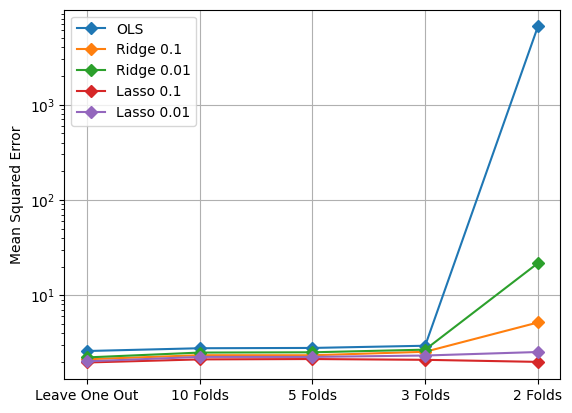

<Figure size 960x720 with 0 Axes>

In [1]:
from numpy import empty
from numpy.random import seed, uniform, normal
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

seed(5)

def Runge(x):
    return 1 / (1 + 25 * x**2)

VARIANCE = 1
N_POINTS = 50

x = uniform(-1, 1, N_POINTS)
y = Runge(x) + normal(0, VARIANCE, N_POINTS)
pol = PolynomialFeatures(degree=10)


def cross_validation(k_folds, optimization_method):
    mean_mse = 0.
    for k in range(k_folds):
        train_idx = [i for i in range(N_POINTS) if i%k_folds!=k]
        test_idx = [i for i in range(N_POINTS) if i%k_folds==k]
        
        x_train = x[train_idx]
        y_train = y[train_idx]

        x_test = x[test_idx]
        y_test = y[test_idx]

        X = pol.fit_transform(x_train.reshape(-1, 1))

        scalar = StandardScaler()
        X = scalar.fit_transform(X)
        y_mean = y_train.mean()
        y_train -= y_mean
        y_train -= y_mean

        reg = optimization_method.fit(X, y_train)

        y_pred = reg.predict(scalar.transform(pol.transform(x_test.reshape(-1, 1))))

        mse = mean_squared_error(y_test, y_pred)

        mean_mse += mse / k_folds

    return mean_mse


for optimization_method, name in [
        (LinearRegression(), "OLS"),
        (Ridge(alpha=0.1), "Ridge 0.1"),
        (Ridge(alpha=0.01), "Ridge 0.01"),
        (Lasso(alpha=0.1), "Lasso 0.1"),
        (Lasso(alpha=0.01), "Lasso 0.01")
    ]:

    mean_mse_LEAVE_ONE_OUT = cross_validation(N_POINTS, optimization_method)
    mean_mse_10_FOLDS = cross_validation(10, optimization_method)
    mean_mse_5_FOLDS = cross_validation(5, optimization_method)
    mean_mse_3_FOLDS = cross_validation(3, optimization_method)
    mean_mse_2_FOLDS = cross_validation(2, optimization_method)

    scalar = StandardScaler()
    X = pol.fit_transform(x.reshape(-1, 1))
    X = scalar.fit_transform(X)
    y_center = y - y.mean()

    reg = optimization_method.fit(X, y_center)
    y_pred = reg.predict(scalar.transform(pol.transform(x.reshape(-1, 1)))) + y.mean()

    print(f"Mean MSE: Leave one out {mean_mse_LEAVE_ONE_OUT:.4f}, 10 folds {mean_mse_10_FOLDS:.4f}, 5 folds {mean_mse_5_FOLDS:.4f}, 3 folds {mean_mse_3_FOLDS:.4f}, 2 folds {mean_mse_2_FOLDS:.4f}")
    plt.plot(range(5), [ mean_mse_LEAVE_ONE_OUT, mean_mse_10_FOLDS, mean_mse_5_FOLDS, mean_mse_3_FOLDS, mean_mse_2_FOLDS], 'D-', label=name)

plt.xticks(range(5), ['Leave One Out', '10 Folds', '5 Folds', '3 Folds', '2 Folds'])
plt.ylabel('Mean Squared Error')
plt.legend()
plt.yscale('log')
plt.grid()
plt.figure(dpi=150)
plt.show()

**Compare cross-validation to bootstrap**

2 Bootstraps 1.1307   3 Bootstraps 0.7742   5 Bootstraps 0.7421   10 Bootstraps 0.7901   50 Bootstraps 0.7698   500 Bootstraps 0.7445   1000 Bootstraps 0.7486   2000 Bootstraps 0.7431   
2 Bootstraps 0.8815   3 Bootstraps 0.9383   5 Bootstraps 0.8211   10 Bootstraps 1.0390   50 Bootstraps 0.9375   500 Bootstraps 0.9285   1000 Bootstraps 0.9188   2000 Bootstraps 0.9383   
2 Bootstraps 0.8423   3 Bootstraps 0.8357   5 Bootstraps 0.9325   10 Bootstraps 0.8524   50 Bootstraps 0.9507   500 Bootstraps 0.8944   1000 Bootstraps 0.9028   2000 Bootstraps 0.9077   
2 Bootstraps 1.0068   3 Bootstraps 1.1208   5 Bootstraps 1.2770   10 Bootstraps 1.2295   50 Bootstraps 1.1409   500 Bootstraps 1.1367   1000 Bootstraps 1.1345   2000 Bootstraps 1.1319   
2 Bootstraps 1.0077   3 Bootstraps 0.8876   5 Bootstraps 0.9749   10 Bootstraps 1.0127   50 Bootstraps 0.9349   500 Bootstraps 0.9551   1000 Bootstraps 0.9603   2000 Bootstraps 0.9586   


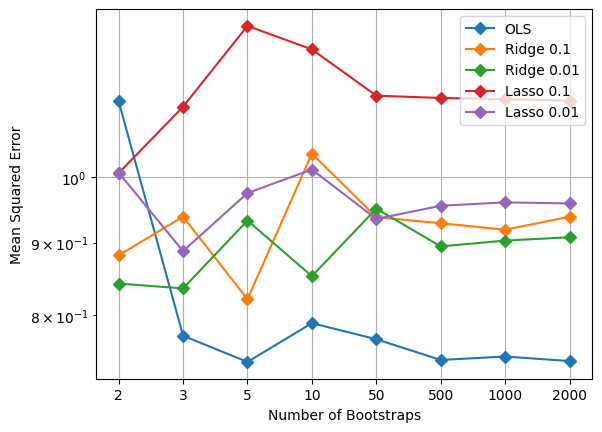

<Figure size 960x720 with 0 Axes>

In [ ]:
n_bootstraps = [2, 3, 5, 10, N_POINTS, 500, 1_000, 2_000]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

def bootstrap(optimization_method, name):

    error = []

    for i, n in enumerate(n_bootstraps):
        y_pred = empty((y_test.shape[0], n))
        for j in range(n):
            x_, y_ = resample(x_train, y_train)

            X = pol.fit_transform(x_.reshape(-1, 1))

            y_pred[:, j] = optimization_method.fit(X, y_).predict(pol.transform(x_test.reshape(-1, 1))).ravel()

        error.append(mean_squared_error(y_test, y_pred.mean(axis=1)))

        print(f"{n} Bootstraps {error[i]:.4f}", end="   ")
    
    print()
    scalar = StandardScaler()
    X = pol.fit_transform(x.reshape(-1, 1))
    X = scalar.fit_transform(X)
    y_center = y - y.mean()

    reg = optimization_method.fit(X, y_center)
    y_pred = reg.predict(scalar.transform(pol.transform(x.reshape(-1, 1)))) + y.mean()

    plt.plot(range(len(n_bootstraps)), error, 'D-', label=name)

for optimization_method, name in [
        (LinearRegression(), "OLS"),
        (Ridge(alpha=0.1), "Ridge 0.1"),
        (Ridge(alpha=0.01), "Ridge 0.01"),
        (Lasso(alpha=0.1), "Lasso 0.1"),
        (Lasso(alpha=0.01), "Lasso 0.01")
    ]:
    bootstrap(optimization_method, name)

plt.xticks(range(len(n_bootstraps)), n_bootstraps)
plt.ylabel('Mean Squared Error')
plt.xlabel('Number of Bootstraps')
plt.legend()
plt.yscale('log')
plt.grid()
plt.figure(dpi=150)
plt.show()